# FINAL PROJECT


## Check cuda working

In [ ]:
!nvidia-smi

Mon May 24 22:42:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.47       Driver Version: 466.47       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8     5W /  N/A |     92MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
from numba import cuda
print(cuda.gpus)

<Managed Device 0>


## Import libraries

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
import os,sys
import torch
import pandas as pd
import seaborn as sns
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import copy
from PIL import Image
import pdb
import random
import numpy.random as npr
from shutil import copyfile
from numpy import asarray
from skimage import io, transform, util

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# For running in local
path_to_folder_train = 'datasets/Training Set/' 
path_to_folder_test = 'datasets/Testset/' 
path_to_folder_test2 = 'datasets/testset2/'

In [ ]:
# For running in google Colab
path_to_folder_train = '/content/drive/MyDrive/Colab Notebooks/computerVision/final project/Train/Training Set' 
path_to_folder_test = '/content/drive/MyDrive/Colab Notebooks/computerVision/final project/Test/Testset' 
path_to_folder_test2 = '/content/drive/MyDrive/Colab Notebooks/computerVision/final project/testset2'

## Data augmentation

In [ ]:
# For testing images in gray scale
def is_grayscale_image(image):
    return (len(image.shape) == 2) or (len(image.shape) == 3 and image.shape[-1] == 1)

In [ ]:
# TESTING TRANSFORMATIONS
# data_dir = path_to_folder

train_transforms = transforms.Compose([#FancyPCA(0.9),
                                       #transforms.Grayscale(num_output_channels=1),
                                       #transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
                                       #transforms.RandomRotation(30),
                                       transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()]) 
                                       #transforms.RandomResizedCrop(224),
test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor()])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(path_to_folder_train, transform=train_transforms)
test_data = datasets.ImageFolder(path_to_folder_test, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32,shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32,shuffle=True)

In [ ]:
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(15,15), nrows=4,ncols=4)
for ii in range(4):
    for jj in range(4):
        ax = axes[ii,jj]
        ax.imshow((images[ii*4+jj,:,:,:]).numpy().transpose((1,2,0)))

In [ ]:
# Train Set
train_transforms = transforms.Compose([#FancyPCA(0.9),
                                       transforms.RandomRotation(30),
                                       transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),
                                       transforms.Resize((224, 224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.Grayscale(num_output_channels=3),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                       ])

# Validation Set
valid_transforms = transforms.Compose([#transforms.Grayscale(num_output_channels=3),
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])
                                       ])
# Test Set
test_transforms = transforms.Compose([#transforms.Grayscale(num_output_channels=3),
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
                                      ])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(path_to_folder_train, transform=train_transforms)
valid_data = datasets.ImageFolder(path_to_folder_test, transform=train_transforms)
test_data = datasets.ImageFolder(path_to_folder_test2, transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers = 6)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True, num_workers = 6)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, num_workers = 6)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Loading the net and modifing the last classification layer


In [ ]:
#model = models.densenet121(pretrained=True)

model = models.googlenet(pretrained= True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 25)
# num_ftrs = model.classifier.in_features
# model.classifier = nn.Linear(num_ftrs, 25)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


In [ ]:
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

Training and evaluation functions

In [ ]:
class Train_Eval():
    
    
    def __init__(self,model,maxiter=500,lr=0.001):

        # We do not inherit, but incorporate the model as an argument
        
        self.model = model
        
        self.lr = lr #Learning Rate
        self.optim = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
        #self.optim = optim.Adam(self.model.classifier.parameters(), self.lr)
        
        self.max_iter = maxiter
        self.criterion = nn.CrossEntropyLoss()
        self.exp_lr_scheduler = lr_scheduler.StepLR(self.optim, step_size=8, gamma=0.1)
        #self.criterion = nn.NLLLoss()             
        
        # A list to store the loss evolution along training
        self.loss_during_training_accum = []
        self.loss_during_training = [] 
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model.to(self.device)
        
    def trainloop(self,trainloader,validloader,bpath,model_name):
        
        best_model_wts = copy.deepcopy(self.model.state_dict())
        #best_aucs = np.zeros((2,)) 
        best_loss = 1000
        best_epoch = -1
        # Optimization Loop
        
        for e in range(int(self.max_iter)):
            start_time = time.time()
                      
            running_loss = 0.
            running_valid_loss = 0.

            # We retrain a certain number of SGD iterations
            for images, labels in trainloader:                      
          
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  

                #Reset Gradients!
                self.optim.zero_grad() 

                # Evaluate output
                out = self.model.forward(images).to(self.device)

                # Evaluate loss
                loss = self.criterion(out,labels).to(self.device)

                running_loss += loss.item()

                #Evaluate gradients
                loss.backward()

                #SGD step
                self.optim.step() #YOUR CODE HERE

            self.loss_during_training_accum.append(running_loss/len(trainloader))
            #self.loss_during_training.append(loss.item())
            self.exp_lr_scheduler.step()
            #print('Batch %d of %d finished. Loss %f' %(e,self.max_iter,running_loss))       

            with torch.no_grad():

                for images_val,labels_val in validloader:
                    images_val, labels_val = images_val.to(self.device), labels_val.to(self.device)  
                    out_valid = self.model.forward(images_val)
                    valid_loss = self.criterion(out_valid, labels_val).to(self.device)
                    running_valid_loss += valid_loss.item()     
                    
            self.valid_loss_during_training.append(running_valid_loss/len(validloader))
            
            if self.valid_loss_during_training[-1] < best_loss:
                best_loss = self.valid_loss_during_training[-1]    
                best_model_wts = copy.deepcopy(self.model.state_dict())
                best_epoch = e
                torch.save({'state_dict':best_model_wts}, os.path.join(bpath, model_name +'_best.pth.tar'))



            if(e % 1 == 0): 

                # print("Training loss after %d epochs: %f" 
                #       %(e,self.loss_during_training[-1]))
                print("Epoch %d. Training loss: %f, Validation loss: %f, Time per epoch: %f seconds, best epoch: %f" 
                      %(e,self.loss_during_training_accum[-1],self.valid_loss_during_training[-1],
                       (time.time() - start_time), best_epoch))
                

    def eval_performance(self,dataloader,num_batches):

        #Your code here
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
          
          it_images = iter(dataloader)
          
          for e in range(int(num_batches)):

                images,labels = next(it_images)
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) #YOUR CODE HERE 
                probs = self.model.forward(images).to(self.device) #YOUR CODE HERE

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
          return accuracy/int(num_batches)

    def get_class(self,image):
        with torch.no_grad():
            image = image.to(self.device) 
            probs = self.model.forward(image).to(self.device) #YOUR CODE H
            top_p, top_class = probs.topk(1, dim=1)
        return top_class


## Training the model

In [ ]:
bpath = 'datasets/'
model_name = 'googlenet'

In [ ]:
#Your code here
my_CNN_4 = Train_Eval(model,maxiter=35)
my_CNN_4.trainloop(trainloader,validloader,bpath,model_name)

In [ ]:
# SAVING THE WEIGHTS
# best_model_wts = copy.deepcopy(my_CNN_3.model.state_dict())
# torch.save({'state_dict':best_model_wts}, os.path.join(bpath, (model_name+'_best.pth.tar')))

In [ ]:
# plt.figure(figsize=(16,4))
# plt.subplot(121)
# plt.plot(my_CNN.loss_during_training,label='Train Loss')
# plt.title('Loss at each iteration')
# plt.legend()

# plt.subplot(122)
# plt.plot(my_CNN.loss_during_training_accum,label='Train Loss')
# plt.title('Loss evolution with number of iterations')
# plt.legend()

In [ ]:
train_acc = my_CNN_3.eval_performance(trainloader,num_batches=300)
#test_acc = my_MLP.eval_performance(testloader,num_batches=10)
valid_acc = my_CNN_3.eval_performance(validloader,num_batches=10)
test_acc = my_CNN_3.eval_performance(testloader,num_batches=1)

In [ ]:
print("Training accuracy: %.2f, Validation accuracy: %.2f,  Test accuracy: %.2f " 
                      %(train_acc*100,valid_acc*100,test_acc*100))


In [ ]:
img_tensor.shape

In [ ]:
img_tensor.unsqueeze(0).shape

In [ ]:
root_dir = 'train_low_res/train_low_res/T/'
tran = transforms.ToTensor()  # Convert the numpy array or PIL.Image read image to (C, H, W) Tensor format and /255 normalize to [0, 1.0]
tran2 = transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])
img = Image.open(root_dir + 'T' + str(9) + '.jpg')
img_tensor = tran(img)
img_tensor = tran2(img_tensor)
img_tensor2 = img_tensor.unsqueeze(0)
img_tensor2 = img_tensor2.to(my_CNN.device)
with torch.no_grad():
    probs = my_CNN.model.forward(img_tensor2) 
top_p, top_class = probs.topk(1, dim=1)
display(img)
print(top_class)

#Confusion matrix

1. Visualize classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


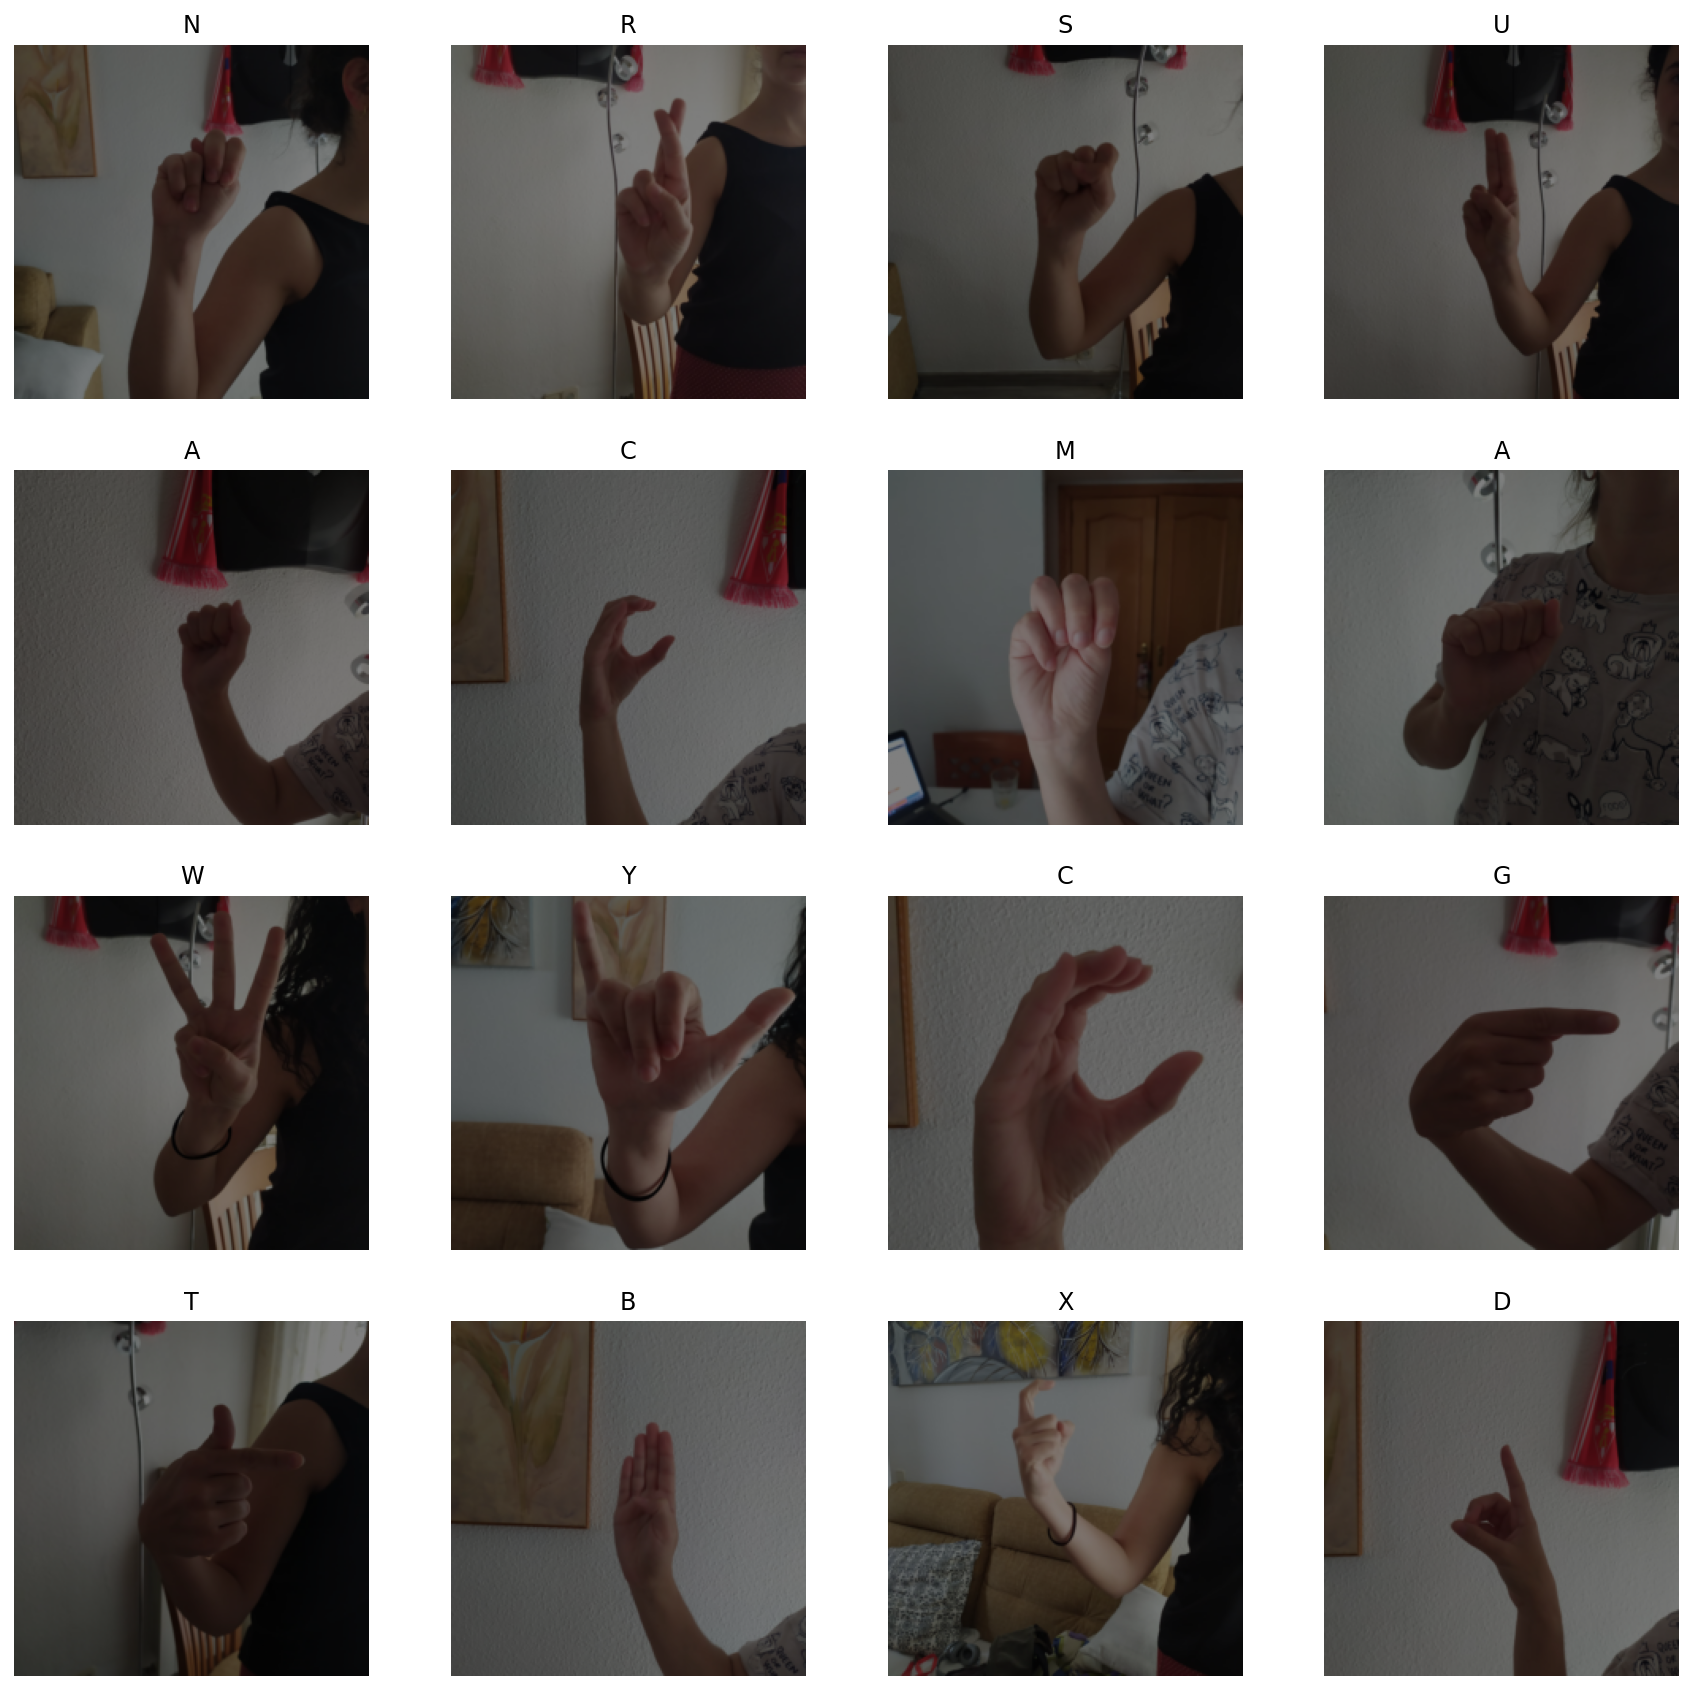

In [ ]:
data_iter = iter(testloader)
images, labels = next(data_iter)
etiquetas = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','space']
def plot_one_sample_of_each(images, labels):
    cols = 4
    rows = int(4)
    fig = plt.figure(figsize=(15, 15))
    
    for i in range(16):
        cls = etiquetas[int(labels[i])]
    
        imgs = (images[i,:,:,:]/2).numpy().transpose((1,2,0))

        sp = plt.subplot(rows, cols, i + 1)
        plt.imshow(imgs)
        plt.title(cls)
        sp.axis('off')

    plt.show()
    return
plot_one_sample_of_each(images, labels)

In [ ]:
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(15,15), nrows=4,ncols=4)
for ii in range(4):
    for jj in range(4):
        ax = axes[ii,jj]
        ax.imshow((images[ii*4+jj,:,:,:]).numpy().transpose((1,2,0)))

In [ ]:
data_iter = iter(validloader)
predictions = []
y = []
with torch.no_grad():
  for i in range(3):
    images, labels = next(data_iter)
    images, labels = images.to(my_CNN_3.device), labels.to(my_CNN_3.device)
    probs = my_CNN_3.model.forward(images).to(my_CNN_3.device) #YOUR CODE HERE
    top_p, top_class = probs.topk(1, dim=1)
    for j in range(64):
      predictions.append(int(top_class[j][0]))
      y.append(int(labels[j]))
print(predictions)
print(y)

In [ ]:
classes = ["Class " + str(i) for i in range(25) ]
print(classification_report(y, predictions, target_names = etiquetas))

In [ ]:
cm = confusion_matrix(y,predictions)

In [ ]:
cm = pd.DataFrame(cm , index = etiquetas, columns = etiquetas)

In [ ]:
cm = pd.DataFrame(cm , index = [i for i in range(26)] , columns = [i for i in range(26)])

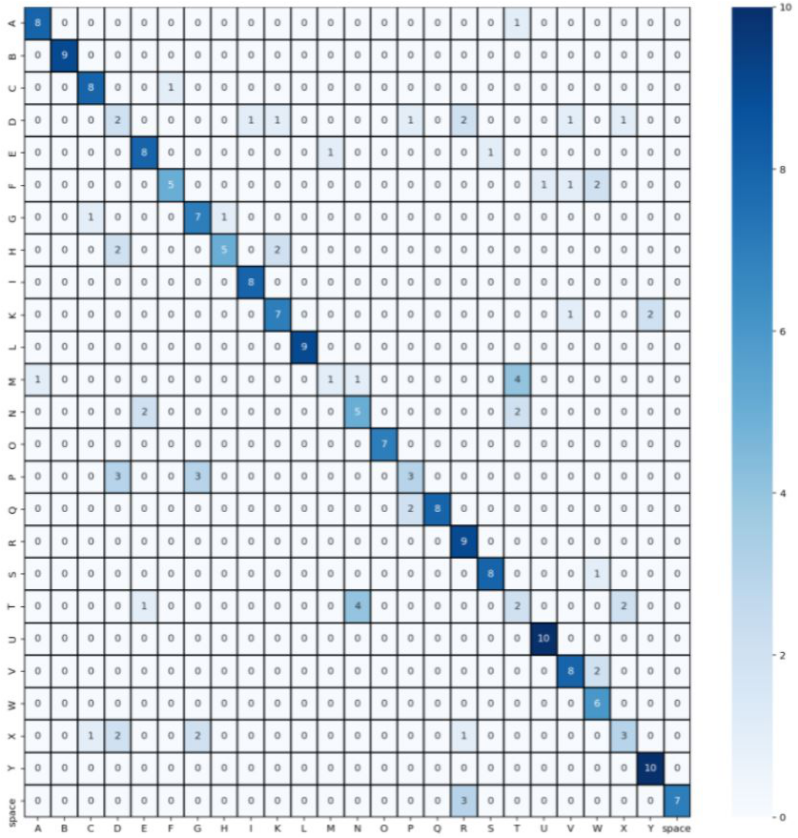

In [12]:
import seaborn as sns
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')